In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
price_weather_df = pd.read_csv('../../processed_data/price_weather_weekly_df-2016-2023.csv',index_col='dt', parse_dates=True)
price_weather_df.drop(columns=['first_day_week'], inplace=True)
price_weather_df

,Alface Americana - Roça,Alface Crespa - Roça,Alface Lisa - Roça,Alface Americana - Atacado,Alface Crespa - Atacado,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),...,TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
dt,,,,,,,,,,,,,,,,,,,,,
2016-04-24 00:00:00+00:00,0.592500,0.616500,0.618000,NaN,NaN,0.000000,907.386111,907.597222,907.213889,805.462393,...,21.968056,20.484722,16.069444,14.787500,75.597222,67.736111,71.763889,219.597222,1.976389,0.140278
2016-05-01 00:00:00+00:00,1.000000,0.426111,0.500000,NaN,NaN,0.145238,905.865476,906.075000,905.628571,358.881090,...,17.910119,17.040476,14.511310,13.772024,84.839286,81.220238,83.279762,174.041667,3.461905,0.521429
2016-05-08 00:00:00+00:00,1.041667,0.437778,0.479444,NaN,NaN,0.021429,909.642262,909.846429,909.453571,559.004533,...,16.691667,15.564881,14.151786,13.103571,88.702381,83.500000,86.303571,197.541667,1.684524,0.204762
2016-05-15 00:00:00+00:00,1.055833,0.430556,0.430556,NaN,NaN,0.215476,909.359524,909.569643,909.135714,346.476328,...,17.743452,16.867262,15.407143,14.588095,89.601190,84.839286,87.196429,189.976190,2.242262,0.270238
2016-05-22 00:00:00+00:00,0.764167,0.444444,0.398333,NaN,NaN,0.115476,908.848810,909.090476,908.598810,406.224192,...,18.666667,17.812500,15.844643,15.135119,87.083333,82.839286,84.976190,208.922619,3.440476,0.574405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03 00:00:00+00:00,1.875000,0.750000,0.750000,1.0,0.5,0.077381,905.600595,905.836012,905.375595,671.860714,...,21.935119,20.800893,18.759821,17.689583,86.452381,79.440476,83.136905,183.988095,4.221131,1.291071
2023-12-10 00:00:00+00:00,1.458333,0.677083,0.677083,1.0,0.5,0.697619,906.600000,906.830357,906.368452,649.313690,...,21.825000,20.777976,19.458929,18.419643,90.095238,84.946429,87.648810,154.059524,3.461310,0.982738
2023-12-17 00:00:00+00:00,1.125000,0.562500,0.562500,1.0,0.5,0.347619,906.604464,906.823512,906.398512,776.282738,...,20.994940,19.836310,17.822917,16.600000,86.422619,79.940476,83.294643,186.979167,3.731845,1.075595


define o tamanho dos conjuntos de treino e de teste

In [3]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# one-step sarima forecast
def sarima_forecast(history, exog, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history,exog=exog, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data,exog, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, exog, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, exog, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, exog, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, exog, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, exog, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, exog, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, exog, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models




In [4]:
print(len(price_weather_df))
print(len(price_weather_df)*0.7)

402
281.4


<Axes: xlabel='dt'>

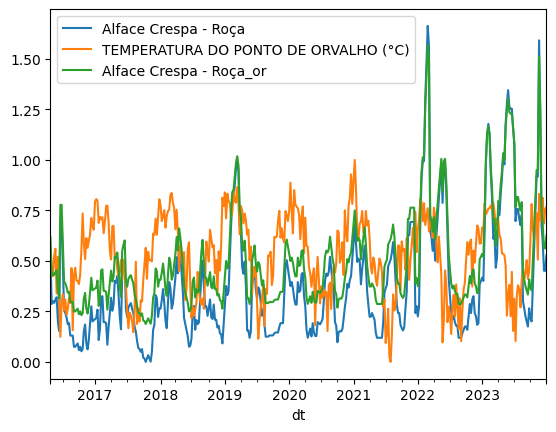

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]

full_dataset = price_weather_df[['Alface Crespa - Roça','TEMPERATURA DO PONTO DE ORVALHO (°C)']]#.rolling(window=12).mean().rolling(window=12).mean()

scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))


normalized_data = full_dataset.copy()
scaler1.fit(price_weather_df[['Alface Crespa - Roça']][:281])
normalized_data['Alface Crespa - Roça'] = scaler1.transform(price_weather_df[['Alface Crespa - Roça']])[:,0]
scaler2.fit(price_weather_df[['TEMPERATURA DO PONTO DE ORVALHO (°C)']][:281])

normalized_data['TEMPERATURA DO PONTO DE ORVALHO (°C)'] = scaler2.transform(price_weather_df[['TEMPERATURA DO PONTO DE ORVALHO (°C)']])[:,0]
normalized_data['Alface Crespa - Roça_or'] = price_weather_df[['Alface Crespa - Roça']]
normalized_data.plot()

200


<Axes: xlabel='dt'>

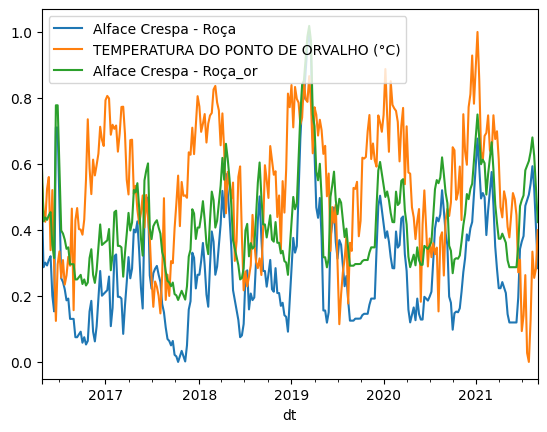

In [6]:
data_train = normalized_data[:281]
data_test = normalized_data[281:]

freqs = list(range(1, 9))
time = np.linspace(0, 2*np.pi, 200)
data = {f"{freq}Hz": np.sin(2 * np.pi * freq * time) for freq in freqs}

df = pd.DataFrame(data)
#df['1Hz'].plot()
print(len(df))
#data_train = df['1Hz'][:140]
#data_test = df['1Hz'][140:]
data_train.plot()

In [7]:

# data split
n_test = 4
# model configs
cfg_list = sarima_configs()
# grid search
scores = grid_search(data_train['Alface Crespa - Roça'], data_train['TEMPERATURA DO PONTO DE ORVALHO (°C)'], cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

scores

done


[]

# Parâmetros do SARIMAX

O modelo **SARIMAX** (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) combina componentes autoregressivos, médias móveis, diferenciação e sazonalidade, podendo também incluir variáveis exógenas.

---

## Parâmetros não sazonais (p, d, q)

- **p (AutoRegressivo - AR)**
  Número de defasagens da variável dependente.
  ➝ Modela a dependência do valor atual com seus próprios valores passados.

- **d (Integração - I)**
  Número de diferenças necessárias para tornar a série estacionária.
  ➝ Remove tendências na série.

- **q (Média Móvel - MA)**
  Número de defasagens dos erros (resíduos) passados.
  ➝ Modela o erro como combinação linear dos erros anteriores.

---

## Parâmetros sazonais (P, D, Q, s)

- **P (Sazonal AutoRegressivo - SAR)**
  Número de defasagens sazonais da série (equivalente a p, mas para ciclos sazonais).

- **D (Sazonal Integração - SI)**
  Número de diferenciações sazonais necessárias.
  ➝ Remove tendências sazonais.

- **Q (Sazonal Média Móvel - SMA)**
  Número de defasagens dos erros sazonais.

- **s (Período sazonal)**
  Tamanho do ciclo sazonal.
  ➝ Exemplos:
    - s=12 → dados mensais com sazonalidade anual.
    - s=7  → dados diários com padrão semanal.
    - s=26 → dados quinzenais com sazonalidade anual (~26 quinzenas).

---

In [8]:
# from pmdarima import auto_arima
#
# auto_model = auto_arima(
#     data_train['Alface Crespa - Roça'],
#     exogenous=data_train[['TEMPERATURA DO PONTO DE ORVALHO (°C)']],
#     seasonal=True,
#     m=26,  # or try m=1 to test no seasonality
#     trace=True
# )
# print(auto_model.summary())

In [9]:
model = SARIMAX(data_train['Alface Crespa - Roça'], exog=data_train['TEMPERATURA DO PONTO DE ORVALHO (°C)'], order=(1, 0, 1), seasonal_order=(0,0,0, 26), trend='ct')
# fit model
model_fit = model.fit(disp=False)
model_fit.summary()

/home/patrick/miniconda3/envs/time-series-analysis/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/patrick/miniconda3/envs/time-series-analysis/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Alface Crespa - Roça   No. Observations:                  281
Model:                 SARIMAX(1, 0, 1)   Log Likelihood                 261.824
Date:                  Sun, 25 May 2025   AIC                           -511.649
Time:                          19:41:12   BIC                           -489.819
Sample:                      04-24-2016   HQIC                          -502.894
                           - 09-05-2021                                         
Covariance Type:                    opg                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                               -0.0099      0.014     -0.698      0.485      -0.038       0.018
drift                                    0.0001   8.51e-05      1.178      0.239   -6.65e-05       0.000
TEMPERATURA DO PONTO DE ORVALHO (°C)     0.5018      0.050      9.955      0.000       0.403       0.601
ar.L1                                    0.7829      0.049     16.030      0.000       0.687       0.879
ma.L1                                    0.1928      0.082      2.342      0.019       0.031       0.354
sigma2                                   0.0090      0.001     14.090      0.000       0.008       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               553.49
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

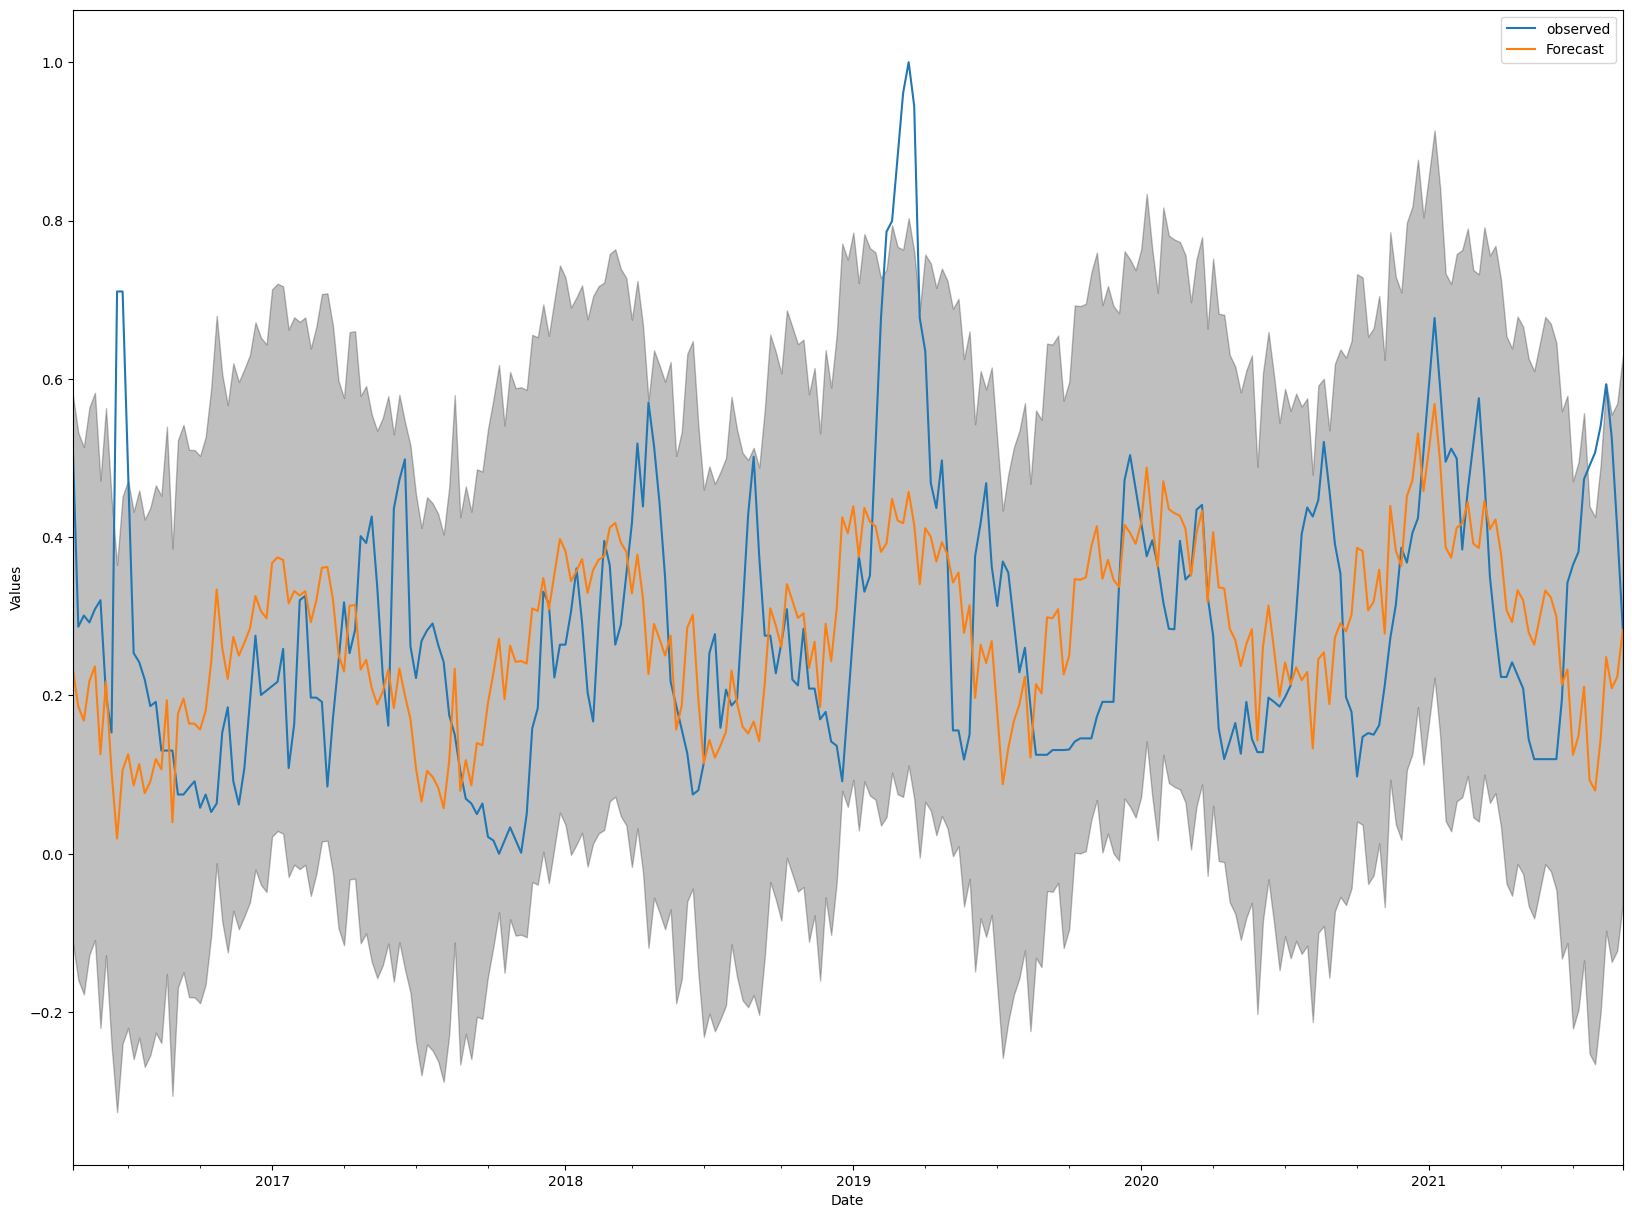

In [10]:
prediction = model_fit.get_prediction(start=0, end=len(data_train)-1, exog=data_test['TEMPERATURA DO PONTO DE ORVALHO (°C)'], dynamic=0)
pred_conf = prediction.conf_int()

ax = data_train['Alface Crespa - Roça'].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
pred_conf.iloc[:, 0],
pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()
plt.show()

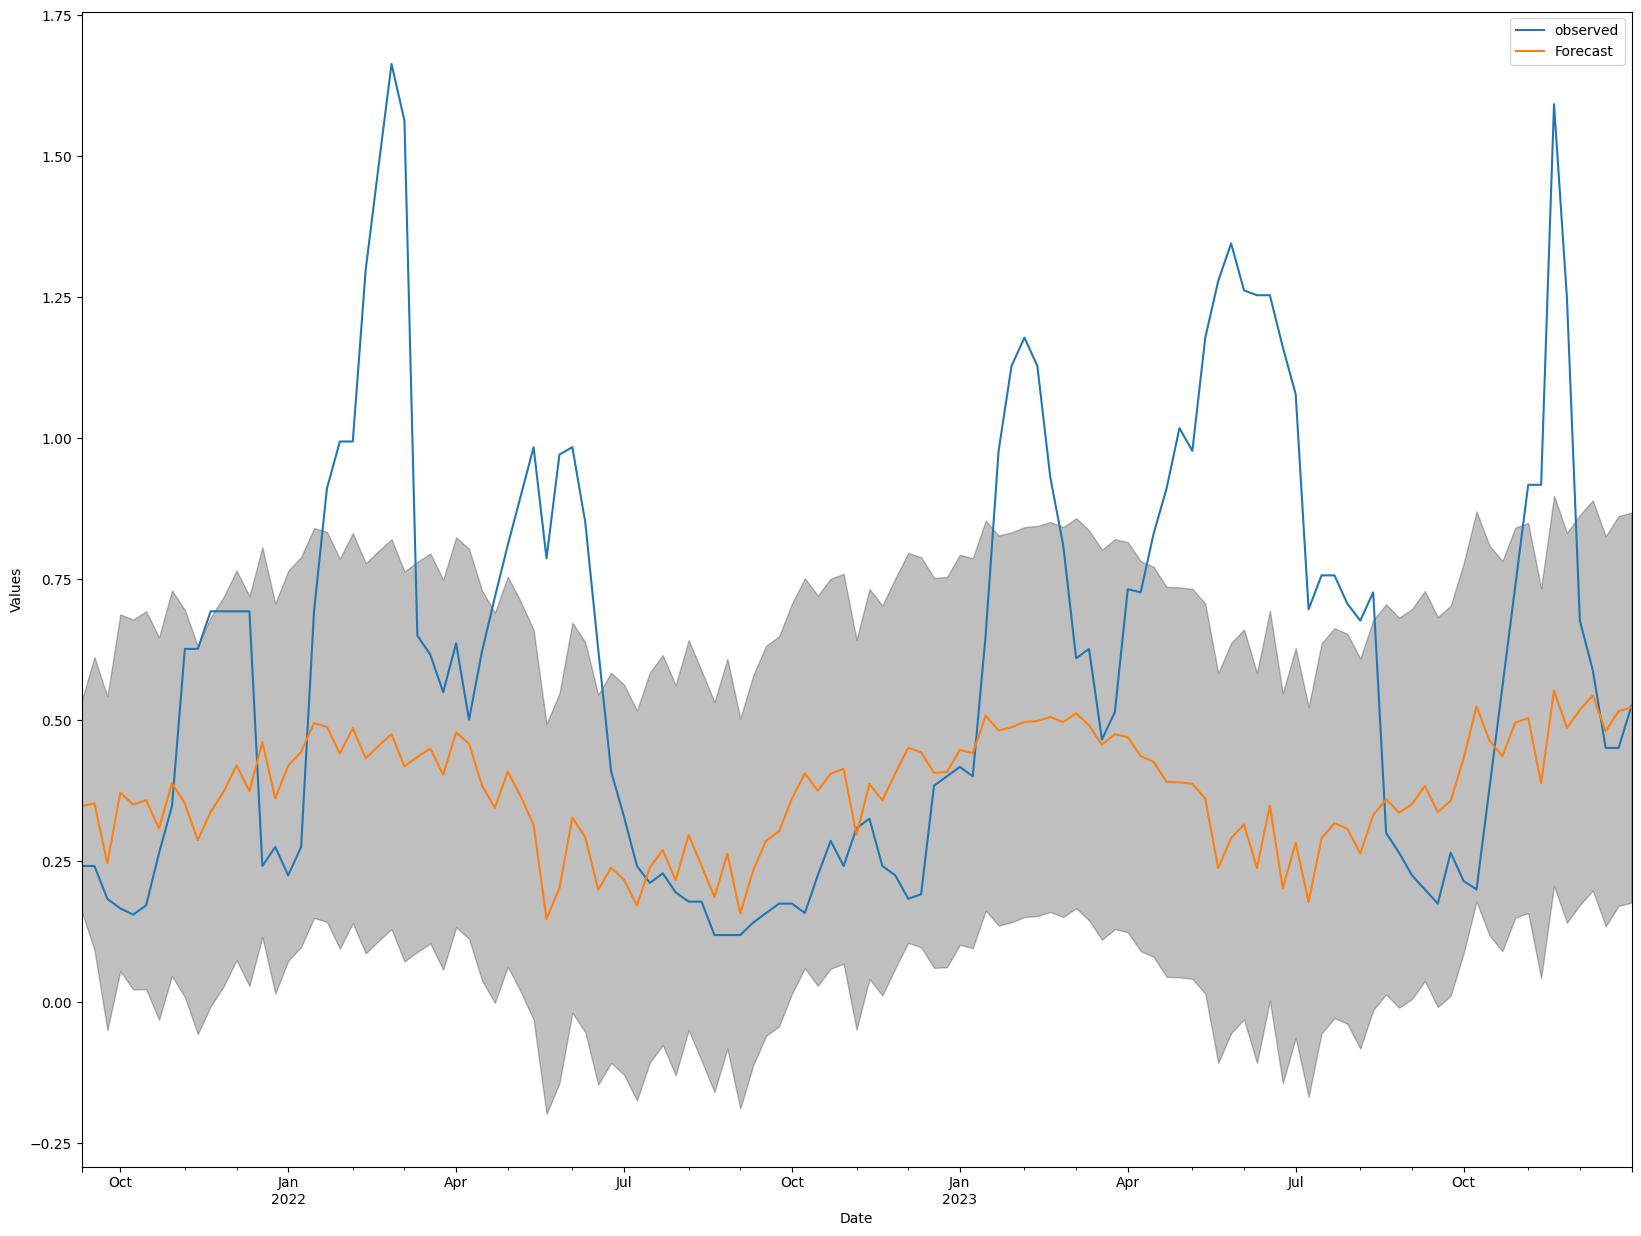

In [11]:


from datetime import datetime

prediction = model_fit.get_forecast(steps=len(data_test), exog=data_test['TEMPERATURA DO PONTO DE ORVALHO (°C)'], dynamic=0)
pred_conf = prediction.conf_int()

ax = data_test['Alface Crespa - Roça'].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
pred_conf.iloc[:, 0],
pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()
plt.show()

In [12]:
measure_rmse(data_test['Alface Crespa - Roça'], prediction.predicted_mean)

0.443223036661042

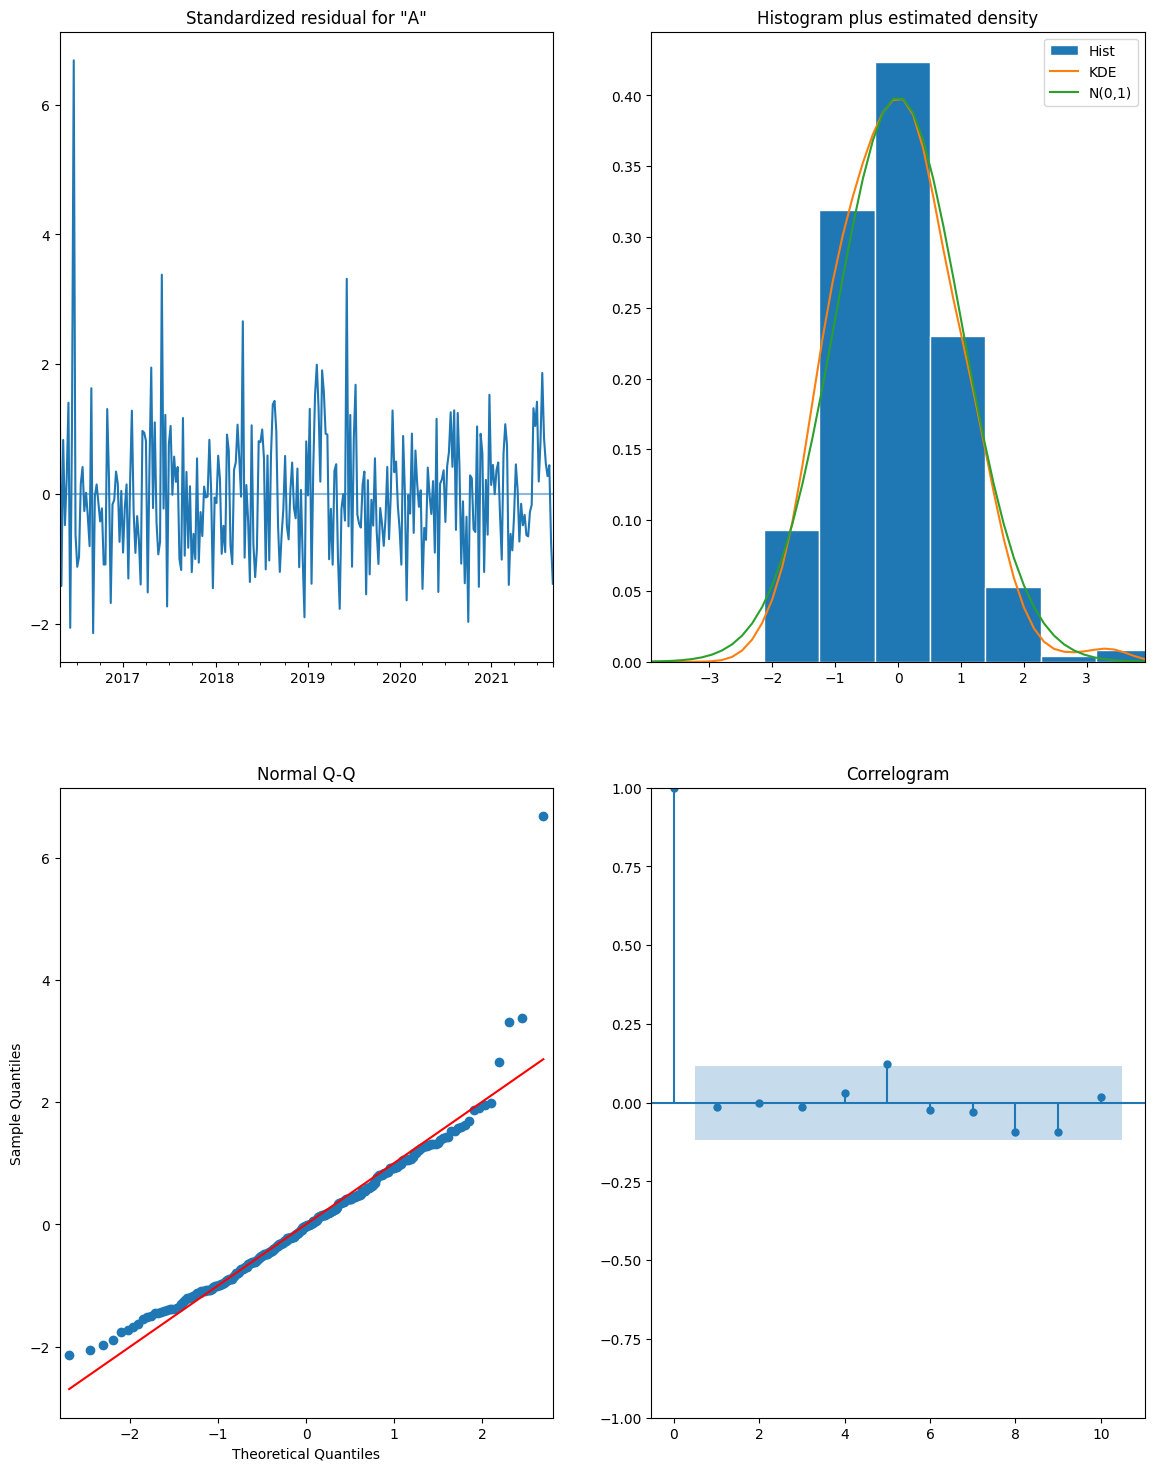

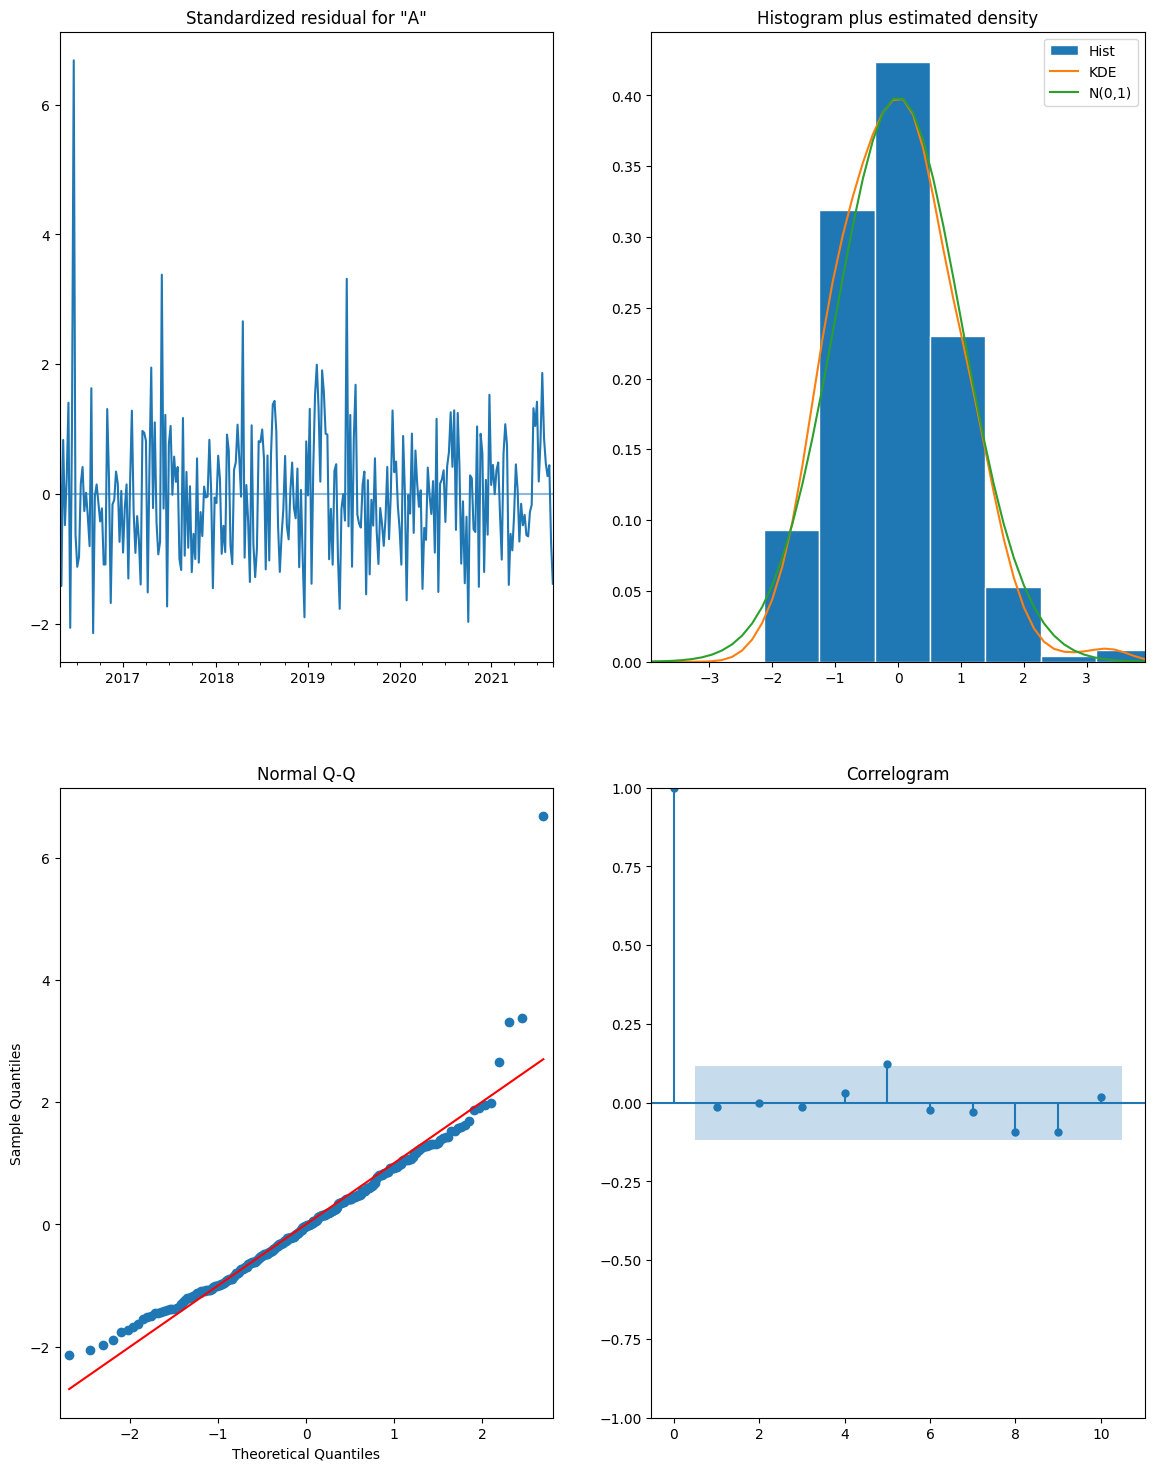

In [13]:
model_fit.plot_diagnostics(figsize=(14,18))